In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

170500096/170498071 [==============================] - 7s 0us/step


In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [5]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [7]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [8]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.103


#### Train model with checkpoints

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [67]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoint/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, frequency='epoch',
                            save_weights_only=True, verbose = 1)

In [68]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x=x_train, y=y_train, epochs=3, callbacks=[checkpoint])

Train on 10000 samples
Epoch 1/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.3469 - accuracy: 0.5168
Epoch 00001: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 40s 4ms/sample - loss: 1.3465 - accuracy: 0.5171
Epoch 2/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.2970 - accuracy: 0.5334
Epoch 00002: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 39s 4ms/sample - loss: 1.2971 - accuracy: 0.5332
Epoch 3/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.2449 - accuracy: 0.5512
Epoch 00003: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 39s 4ms/sample - loss: 1.2452 - accuracy: 0.5509


In [69]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoint

total 184K
-rw-r--r-- 1 jovyan users   77 May 19 16:04 checkpoint
-rw-r--r-- 1 jovyan users 174K May 19 16:04 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K May 19 16:04 checkpoint.index


In [70]:
# Evaluate the performance of the trained model

get_test_accuracy(model,x_test,y_test)

accuracy: 0.509


#### Create new model, load weights

In [15]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.078


In [16]:
# Load weights -- accuracy is the same as the trained model

model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.447


#### Clear directory

In [71]:
! rm -r model_checkpoint

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [73]:
# Create Tensorflow checkpoint object with epoch and batch details

checkpoint_5000_path = \
'model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:02d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                 save_weights_only=True,
                                 save_freq=5000,verbose=1)

In [74]:
# Create and fit model with checkpoint

model=get_new_model()
model.fit(x_train, y_train, epochs=3, validation_data=(x_test,y_test),
         batch_size=10, callbacks=[checkpoint_5000])

Train on 10000 samples, validate on 1000 samples
Epoch 1/3
 4990/10000 [=============>................] - ETA: 24s - loss: 1.9864 - accuracy: 0.2543
Epoch 00001: saving model to model_checkpoints_5000/checkpoint_01_499
 9970/10000 [============================>.] - ETA: 0s - loss: 1.8332 - accuracy: 0.3174
Epoch 00001: saving model to model_checkpoints_5000/checkpoint_01_999
10000/10000 [==============================] - 50s 5ms/sample - loss: 1.8325 - accuracy: 0.3179 - val_loss: 1.6263 - val_accuracy: 0.4180
Epoch 2/3
 4990/10000 [=============>................] - ETA: 23s - loss: 1.5153 - accuracy: 0.4609
Epoch 00002: saving model to model_checkpoints_5000/checkpoint_02_499
 9980/10000 [============================>.] - ETA: 0s - loss: 1.4901 - accuracy: 0.4630
Epoch 00002: saving model to model_checkpoints_5000/checkpoint_02_999
10000/10000 [==============================] - 49s 5ms/sample - loss: 1.4904 - accuracy: 0.4629 - val_loss: 1.4977 - val_accuracy: 0.4600
Epoch 3/3
 4990/1

In [75]:
# Have a look at what the checkpoint creates

!ls -lh model_checkpoints_5000
# !rm -rf model_checkpoints_5000

total 1.1M
-rw-r--r-- 1 jovyan users   91 May 19 16:07 checkpoint
-rw-r--r-- 1 jovyan users 174K May 19 16:05 checkpoint_01_499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K May 19 16:05 checkpoint_01_499.index
-rw-r--r-- 1 jovyan users 174K May 19 16:06 checkpoint_01_999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K May 19 16:06 checkpoint_01_999.index
-rw-r--r-- 1 jovyan users 174K May 19 16:06 checkpoint_02_499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K May 19 16:06 checkpoint_02_499.index
-rw-r--r-- 1 jovyan users 174K May 19 16:06 checkpoint_02_999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K May 19 16:06 checkpoint_02_999.index
-rw-r--r-- 1 jovyan users 174K May 19 16:07 checkpoint_03_499.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K May 19 16:07 checkpoint_03_499.index
-rw-r--r-- 1 jovyan users 174K May 19 16:07 checkpoint_03_999.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K May 19 16:07 checkpoint_03_999.index


#### Work with model saving criteria

In [76]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [77]:
# Create a new instance of untrained model

model = get_new_model()

In [78]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                 save_weights_only=True,
                                 save_freq='epoch',
                                 monitor = 'val_accuracy',
                                 save_best_only=True,
                                 verbose=1)

In [79]:
# Fit the model and save only the weights with the highest validation accuracy

history = model.fit(x_train, y_train,
                   epochs=50,
                   validation_data=(x_test, y_test),
                   batch_size=10,
                   callbacks=[checkpoint_best],
                   verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.06000, saving model to model_checkpoints_best/checkpoint

Epoch 00002: val_accuracy did not improve from 0.06000

Epoch 00003: val_accuracy improved from 0.06000 to 0.08000, saving model to model_checkpoints_best/checkpoint

Epoch 00004: val_accuracy did not improve from 0.08000

Epoch 00005: val_accuracy improved from 0.08000 to 0.10000, saving model to model_checkpoints_best/checkpoint

Epoch 00006: val_accuracy improved from 0.10000 to 0.11000, saving model to model_checkpoints_best/checkpoint

Epoch 00007: val_accuracy did not improve from 0.11000

Epoch 00008: val_accuracy did not improve from 0.11000

Epoch 00009: val_accuracy did not improve from 0.11000

Epoch 00010: val_accuracy improved from 0.11000 to 0.13000, saving model to model_checkpoints_best/checkpoint

Epoch 00011: val_accuracy improved from 0.13000 to 0.16000, saving model to model_checkpoints_best/checkpoint

Epoch 00012: val_accuracy did not improve from 0.16000



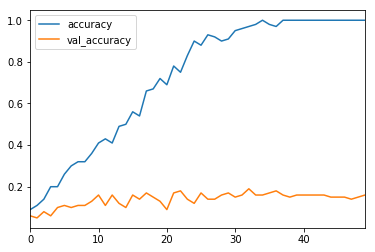

In [80]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [81]:
# Inspect the checkpoint directory

!ls model_checkpoints_best
# !rm -rf model_checkpoints_best

checkpoint  checkpoint.data-00000-of-00001  checkpoint.index


In [82]:
# Create a new model with the saved weights

new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model,x_test,y_test)

accuracy: 0.190


#### Clear directory

In [83]:
! rm -r model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            save_freq='epoch',
                            save_weights_only=False,
                            verbose=1)

In [9]:
# Create and fit model with checkpoint

model = get_new_model()
history = model.fit(x_train, y_train, epochs=3, callbacks=[checkpoint])

Train on 10000 samples
Epoch 1/3
 9984/10000 [============================>.] - ETA: 0s - loss: 2.0296 - accuracy: 0.2525
Epoch 00001: saving model to model_checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_checkpoint/assets
10000/10000 [==============================] - 43s 4ms/sample - loss: 2.0294 - accuracy: 0.2527
Epoch 2/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.6890 - accuracy: 0.3891
Epoch 00002: saving model to model_checkpoint
INFO:tensorflow:Assets written to: model_checkpoint/assets
10000/10000 [==============================] - 42s 4ms/sample - loss: 1.6895 - accuracy: 0.3891
Epoch 3/3
 9984/10000 [============================>.] - ETA: 0s - loss: 1.5639 - accuracy: 0.4325
Epoch 00003: saving model to model_checkpoint
INFO:tensorflow:Assets written to: model_checkpoint/assets
10000/10000 [==============================] - 41s 4ms/sample - loss: 1.5636 - accuracy: 0.4

#### Inspect what the checkpoint has created

In [11]:
# Have a look at what the checkpoint creates

!ls model_checkpoint -lh

total 128K
drwxr-xr-x 2 jovyan users 6.0K May 19 18:48 assets
-rw-r--r-- 1 jovyan users 119K May 19 18:49 saved_model.pb
drwxr-xr-x 2 jovyan users 6.0K May 19 18:49 variables


In [14]:
# Enter variables directory

!ls model_checkpoint/variables/ -lh

total 184K
-rw-r--r-- 1 jovyan users 177K May 19 18:49 variables.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.1K May 19 18:49 variables.index


In [15]:
# Get the model's test accuracy

get_test_accuracy(model, x_test, y_test)

accuracy: 0.435


#### Create new model from scratch

In [16]:
# Delete model

del model

In [17]:
from tensorflow.keras.models import load_model

In [18]:
# Reload model from scratch

model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.435


#### Use the .h5 format to save model

In [26]:
# Save the model in .h5 format

model.save('my_model.h5')

In [27]:
# Inspect .h5 file

!ls -lh my_model.h5

-rw-r--r-- 1 jovyan users 77K May 19 18:58 my_model.h5


In [28]:
# Delete model

del model

In [29]:
# Reload model from scratch

model = tf.keras.models.load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.435


#### Clear directory

In [33]:
!ls -lh

total 68K
-rwxrwxrwx 1 nobody nogroup  57K May 19 19:00 'Coding Tutorial.ipynb'
drwxrwxrwx 2 nobody nogroup 6.0K May 17 15:04  data
drwxrwxrwx 3 nobody nogroup 6.0K May 17 15:04  models


In [32]:
! rm -r model_checkpoints
! rm my_model.h5
! rm -r checkpoint_files model_checkpoint

rm: cannot remove 'model_checkpoints': No such file or directory
rm: cannot remove 'my_model.h5': No such file or directory


***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [34]:
from tensorflow.keras.models import load_model

In [35]:
# Build Keras ResNet50 model

model = load_model('models/Keras_ResNet50.h5')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Import and preprocess 3 sample images

In [36]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('data/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('data/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [50]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    print(np.ndim(preds))
    print(preds[0][0])
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

In [43]:
print(np.arange(5))
np.arange(5)+1

[0 1 2 3 4]


array([1, 2, 3, 4, 5])

##### Image 1: lemon

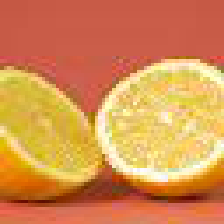

In [38]:
# Display image

lemon_img

In [51]:
# Display top 5 predictions

get_top_5_predictions(lemon_img)

3
('n07584110', 'consomme', 0.22780065)


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.0400883
5,spotlight,0.0291972


##### Image 2: viaduct

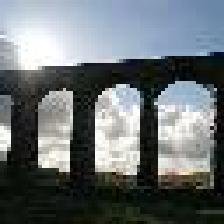

In [54]:
# Display image

viaduct_img

In [55]:
# Display top 5 predictions

get_top_5_predictions(viaduct_img)

3
('n04523525', 'vault', 0.36795092)


,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.0882309
5,fire_screen,0.0206752


##### Image 3: water tower

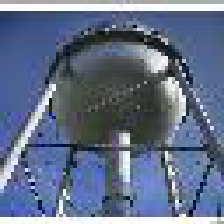

In [52]:
# Display image

water_tower_img

In [53]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)

3
('n04258138', 'solar_dish', 0.38468105)


,prediction,probability
1,solar_dish,0.384681
2,ladle,0.196179
3,planetarium,0.116682
4,strainer,0.04999
5,jigsaw_puzzle,0.0219473


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [56]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [63]:
# Build Google's Mobilenet v1 model

module = load_model('models/Tensorflow_MobileNet_v1')
model = Sequential(hub.KerasLayer(module, trainable=False))
model.build(input_shape=[None,160,160,3])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   multiple                  1343049   
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [64]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("data/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("data/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("data/water_tower.jpg", target_size=(160, 160))

In [65]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [66]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    print(sorted_index)
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

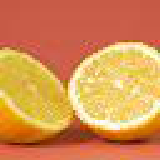

In [67]:
lemon_img

In [68]:
get_top_5_predictions(lemon_img)

[794 869 471 ... 145 676 392]


,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

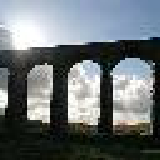

In [69]:
viaduct_img

In [70]:
get_top_5_predictions(viaduct_img)

[889 719 526 ...  98 306  43]


,prediction
1,viaduct
2,pier
3,dam
4,prison
5,solar dish


##### Image 3: water tower

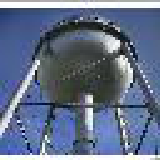

In [71]:
water_tower_img

In [72]:
get_top_5_predictions(water_tower_img)

[808 901 404 ... 131  49 987]


,prediction
1,solar dish
2,water tower
3,aircraft carrier
4,jigsaw puzzle
5,oxygen mask
